In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sympy as sp
from sympy import pretty_print
from textwrap import dedent
from IPython.display import display
from ipywidgets import interactive

## Solow-Swan Model

#### Aggregate Output Function and Transition Equations

$$ Y_t = zK_t^\alpha L_t^{1-\alpha}$$

where:
$$\begin{align}
K_{t+1} &= sY_t - (n+d)K_t \\
C_{t} &= (1-s)Y_t \\
N_{t+1} &= (1+n)N_t
\end{align}$$

#### Per capita Output Function and Transition Equations

$$ y_t = zk_t^\alpha$$

where:
$$\begin{align}
k_{t+1} &= \frac{sy_t + (1-d)k_t}{1+n} \\
c_{t} &= (1-s)y_t \\
\end{align}$$

Next, we use `sympy` to solve analytically for the steady state values of output, capital and consumption per capita:

'Steady state per capita capital'

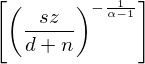

[(s*z/(d + n))**(-1/(alpha - 1))]

In [25]:
# SOLVING FOR THE STEADY STATE VALUES
## variables:
y, k, c = sp.symbols('y, k, c')

## parameters:
z, s, d, n, alpha = sp.symbols('z, s, d, n, alpha')

## capital per capita 
y = z*k**alpha
kss = k - (s*y + (1-d)*k)/(1+n)

init_printing(pretty_print=True)
display("Steady state per capita capital", solve(kss, k))
init_printing(pretty_print=False)
display(solve(kss, k))

'Steady state per capita output'

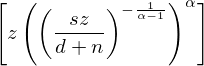

[z*((s*z/(d + n))**(-1/(alpha - 1)))**alpha]

In [27]:
## output per capita
k = (s*z/(d + n))**(-1/(alpha - 1))
yss = y - z*k**alpha

init_printing(pretty_print=True)
display("Steady state per capita output" ,solve(yss, y))
init_printing(pretty_print=False)
display(solve(yss, y))

'Steady state per capita output'

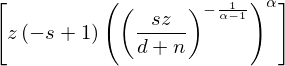

[z*(-s + 1)*((s*z/(d + n))**(-1/(alpha - 1)))**alpha]

In [28]:
## consumption per capita
y = z*((s*z/(d + n))**(-1/(alpha - 1)))**alpha
CSS = c - (1-s)*y
init_printing(pretty_print=True)
display("Steady state per capita output", solve(CSS, c))
init_printing(pretty_print=False)
display(solve(CSS, c))

In [233]:
class SolowSwan():
    """ SolowSwan Model Simulation """
    def __init__(self, z = 1.0, alpha = 0.33, L = 10, K = 10,
                s = 0.2, d = 0.05, n = 0.02):
        """ Model Initialization """
        # we admit only non-negative values
        positive_array = np.array([z, alpha, L, K, s, d, n])
        zeros = np.zeros(len(positive_array))
        if np.any(np.less_equal(positive_array, zeros)):
            raise ValueError("Only positive values admitted.")
        
        # create class attributes for SolowSwan
        self.z = z
        self.alpha, self.beta = alpha, 1-alpha
        self.L, self.K = L, K
        self.s, self.d, self.n = s, d, n
        
    def __repr__(self):
        " Basic Information about the model "
        return self.__str__()
    
    def __str__(self):
        message = """Solow-Swan model with the following features:
        - Capital (K) = {K}
        - Labor (L) = {L}
        - Total factor productivity = {z}
        - Income share of Capital (alpha) = {alpha}
        - Income share of Labor (beta) = {beta}
        - Saving rate (s) = {s}
        - Depreciation rate (d) = {d}
        - Population growth rate (n) = {n}"""
        
        return dedent(message.format(K = self.K, L = self.L, z =self.z,
                                    alpha = self.alpha, beta = self.beta,
                                    s = self.s, d = self.d, n = self.n))
    
    def TotalOutput(self):
        z, alpha, beta = self.z, self.alpha, self.beta
        return z*(self.K**alpha)*(self.L**self.beta)
    
    def perCapOutput(self, k=None):
        if k is None: 
            k = self.K/self.L
        return self.z*k**self.alpha
    
    def ss_analytic(self):
        z, alpha, beta, s, d, n = self.z, self.alpha, self.beta, self.s, self.d, self.n
        kss = (s*z/(d + n))**(-1/(alpha - 1))
        yss = z*kss**alpha
        css = (1-s)*yss
        # store values as attributes
        self.kss, self.yss, self.css = kss, yss, css
        
        return kss, yss, css
    
    def ss_numerical(self, k0 = None, tol = 1e-4, maxiter=200):
        """ Compute the steady state values via an iterative procedure """
        
        z, alpha, beta, s, d, n = self.z, self.alpha, self.beta, self.s, self.d, self.n
            
        if k0 is None: 
            k0 = self.K/self.L
            
        y0 = self.perCapOutput(k0)
            
        error = 1
        i = 0
       
        while i < maxiter and error > tol:
            knext = (s*y0 + (1-d)*k0)/(1+n)
            error = np.abs(knext-k0)
            if error < tol:
                break
            k0 = knext
            y0 = self.perCapOutput(k0)
            i += 1
        
        kss = knext
        yss = y0
        css = (1-s)*yss
        return kss, yss, css
        
    def next_value_generator(self, T, k0=None):
        """ Create a generator for the transition paths of k, y and c"""
        z, alpha, beta, s, d, n = self.z, self.alpha, self.beta, self.s, self.d, self.n
         
        ## if k0 is not provided, then adopt the ss value of k
        if k0 is None:
            k0 = self.K/self.L
            
        ## set initial values
        k_next = k0
        y_next = self.perCapOutput(k_next)
        c_next = (1-s)*y_next
        for t in range(T):
            yield k_next, y_next, c_next
            k_next = (s*y_next + (1-d)*k_next)/(1+n)
            y_next = self.perCapOutput(k=k_next)
            c_next = (1-s)*y_next
            
    def transition_paths(self, **kwargs):
        """ Simulate transition paths using the next_value_generator module"""
        z, alpha, beta, s, d, n = self.z, self.alpha, self.beta, self.s, self.d, self.n
        
        paths = np.array(list(self.next_value_generator(**kwargs)))
        self.k_path = paths[:,0]
        self.y_path = paths[:,1]
        self.c_path = paths[:,2]
        

In [182]:
np.not_equal([1, 1],[0.,0.])

array([ True,  True])

In [146]:
list(range(1,10))

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [220]:
m = SolowSwan(z=3)

In [221]:
m.transition_paths(T=100)
m.k_path

array([ 1.        ,  1.51960784,  2.09066104,  2.69750111,  3.32852554,
        3.97486797,  4.62961207,  5.28728921,  5.94353882,  6.59486839,
        7.23847763,  7.87212591,  8.49403   ,  9.10278357,  9.69729289,
       10.27672474, 10.84046374, 11.38807715, 11.91928544, 12.43393774,
       12.93199104, 13.41349267, 13.87856531, 14.32739431, 14.76021678,
       15.17731223, 15.57899467, 15.96560566, 16.33750845, 16.69508291,
       17.03872122, 17.36882408, 17.68579758, 17.99005044, 18.2819917 ,
       18.56202875, 18.83056566, 19.08800176, 19.33473048, 19.57113841,
       19.79760443, 20.01449915, 20.22218434, 20.42101255, 20.61132681,
       20.79346045, 20.96773691, 21.13446972, 21.29396243, 21.44650871,
       21.59239236, 21.73188745, 21.86525844, 21.99276035, 22.11463892,
       22.23113083, 22.34246391, 22.44885731, 22.55052179, 22.64765992,
       22.74046632, 22.8291279 , 22.91382408, 22.99472709, 23.07200214,
       23.14580768, 23.21629566, 23.28361172, 23.34789542, 23.40

In [222]:
m.ss_analytic()

(24.69543792333115, 8.643403273165902, 6.914722618532721)

In [223]:
m.ss_numerical()

(24.692713458647063, 8.64308858586437, 6.914470868691495)

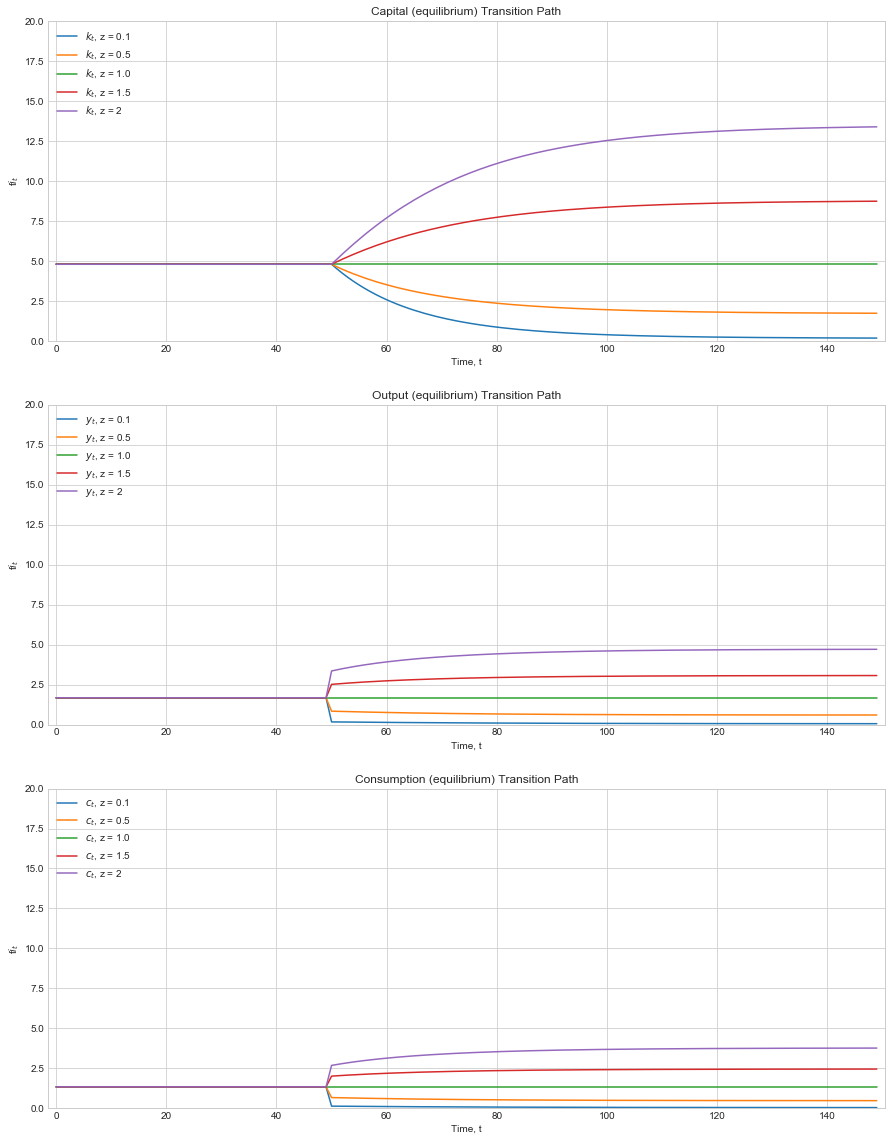

In [234]:
## Visualization

m = SolowSwan()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20))

ss = m.ss_analytic() # this generates 3 ss values for m instance

kss_path = np.array([m.kss,]*50)
yss_path = np.array([m.yss,]*50)
css_path = np.array([m.css,]*50)

plt.rcParams['axes.xmargin'] = 0.01
plt.rcParams['axes.ymargin'] = 0.01
plt.style.use('seaborn-whitegrid')


for z in [0.1, 0.5, 1.0, 1.5, 2]:
    m.z = z
    m.transition_paths(T=100, k0=m.kss);
    ## ax.plot(np.array([kss_path, m.k_path]).flatten())
    k_series = np.concatenate((kss_path, m.k_path), axis=0)
    y_series = np.concatenate((yss_path, m.y_path), axis=0)
    c_series = np.concatenate((css_path, m.c_path), axis=0)
    ax1.plot(k_series, label=f"$k_t$, z = {z}", alpha=3)
    ax2.plot(y_series, label=f"$y_t$, z = {z}", alpha=3)
    ax3.plot(c_series, label=f"$c_t$, z = {z}", alpha=3)
    
ax_list = (ax1, ax2, ax3)
ylabel_list = ('k', 'y', 'c')
for ax, i in zip(ax_list, ylabel_list):
    ax.set_xlabel("Time, t")
    ax.set_ylabel("f${i}_t$")
    ax.legend(loc="upper left", fontsize=10)
    ax.set_ylim(0,20)
    
ax1.set_title("Capital (equilibrium) Transition Path")
ax2.set_title("Output (equilibrium) Transition Path")
ax3.set_title("Consumption (equilibrium) Transition Path")

plt.show()


In [250]:
def plotting(z=1, alpha=0.33, s=0.2, d=0.05, n=0.02):
    m = SolowSwan()
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20))
    ss = m.ss_analytic() # this generates 3 ss values for m instance

    kss_path = np.array([m.kss,]*50)
    yss_path = np.array([m.yss,]*50)
    css_path = np.array([m.css,]*50)

    plt.rcParams['axes.xmargin'] = 0.01
    plt.rcParams['axes.ymargin'] = 0.01
    plt.style.use('seaborn-whitegrid')

    # introduce shock
    m.z, m.alpha = z, alpha
    m.s, m.d, m.n = s, d, n
    m.transition_paths(T=100, k0=m.kss);
    ## ax.plot(np.array([kss_path, m.k_path]).flatten())
    k_series = np.concatenate((kss_path, m.k_path), axis=0)
    y_series = np.concatenate((yss_path, m.y_path), axis=0)
    c_series = np.concatenate((css_path, m.c_path), axis=0)
    ax1.plot(k_series, label=f"$k_t$, z = {z}", alpha=3)
    ax2.plot(y_series, label=f"$y_t$, z = {z}", alpha=3)
    ax3.plot(c_series, label=f"$c_t$, z = {z}", alpha=3)
    
    ax_list = (ax1, ax2, ax3)
    ylabel_list = ('k', 'y', 'c')
    for ax, i in zip(ax_list, ylabel_list):
        ax.set_xlabel("Time, t")
        ax.set_ylabel("f${i}_t$")
        ax.legend(loc="upper left", fontsize=10)
        ax.set_ylim(0,20)
    
    ax1.set_title("Capital (equilibrium) Transition Path")
    ax2.set_title("Output (equilibrium) Transition Path")
    ax3.set_title("Consumption (equilibrium) Transition Path")

    plt.show()

In [251]:
interactive_plot = interactive(plotting, z=(0.1,3,0.1), 
                               alpha=(0.1, 1, 0.1),
                               L=(5,100,1), 
                               K=(5,500,10),
                               s=(0.1,0.9,0.1),
                               d=(0.01,0.9,0.1),
                               n=(0.01,0.3,0.01))
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='z', max=3.0, min=0.1), FloatSlider(value=0.33, descr…